<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGD, PQN, PMGD, SOUL, and VI to the Bayesian logistic regression example in Section 3.1 of [Particle algorithms for maximum likelihood training of latent
variable models](https://juankuntz.github.io/publication/parem/) and reproduces Figure 3 and Table 1 therein. 

# Figure 3

In [1]:
#@title Load modules.

# Install the wget package on Colab (if running the notebook locally,
# comment the following line out).
#!pip install wget

# OS and wget to load dataset.
import os
import wget
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform

# Numpy for computations.
import autograd.numpy as np
from autograd import grad

# Pyplot for plots.
import matplotlib.pyplot as plt 

#@title Load and normalize the Wisconsin Breast Cancer dataset.

# Fetch dataset from repository:
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data')

# Load dataset:
dataset = np.loadtxt('breast-cancer-wisconsin.data', dtype=str, delimiter=',')

# Delete local copy of dataset to avoid duplicates with multiple notebook runs:
os.remove('breast-cancer-wisconsin.data')

# Remove datapoints with missing attributes and change dtype to float:
dataset = dataset[~(dataset == '?').any(axis=1), :].astype(float)

# Extract features and labels, and normalize features:
features = np.array(dataset[:, 1:10] - dataset[:, 1:10].mean(0))
features = features/features.std(0)
labels = np.array([(dataset[:, 10]-2)/2]).transpose()

In [281]:
from coinem.model import AbstractModel
from jaxtyping import Array, Float
from dataclasses import dataclass
import jax.numpy as jnp

from jax import grad, vmap

@dataclass
class LogisticRegression(AbstractModel):
    """Base class for p(θ, x)."""
    X: Array # Inputs
    y: Array # Outputs
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"]) -> Float[Array, ""]:
        """Compute gradient of the objective function at x.

        Args:
            latent (Float[Array, "D"]): Input weights of shape (D,).
            theta (Float[Array, "Q"]): Parameters of shape (Q,).

        Returns:
            Float[Array, ""]: log-probability of the data.
        """

        # Compute linear predictor.
        z = jnp.matmul(self.X, latent[:, None])

        # Compute log-probability.
        return jnp.sum(self.y * z - jnp.log(1.0 + jnp.exp(z))) - jnp.sum((latent[:, None]-theta)**2)/5

First, we load the modules that we will need:

We run the algorithms using an 80/20 training/test split of the data:

In [285]:
from coinem.zoo import coinEM, pgd

# Split data into 80/20 training and testing sets:
from sklearn.model_selection import train_test_split
ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2, 
                                                random_state=0)

likelihood = LogisticRegression(X=ftrain, y=ltrain)

# Set approximation parameters:
h = 1e-2 # Step-size. 
K = 400  # Number of steps.
N = 100  # Number of particles.
D = features[0, :].size  # Dimension of latent space.

# Initialize parameter estimates and particle cloud, all at zero:


import jax.random as jr
th0 = jnp.array([[0.0]])  # Parameter estimate.
key = jr.PRNGKey(42)
X0 = jr.normal(key, (N, D))  # Particle cloud.

# Run algorithms:
# th_vi, X_vi, m_vi, s_vi = vi(ltrain, ftrain, h, K, N, th0, X0)
# th_pgd, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
# th_pqn, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
# th_pmgd, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
# th_soul, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)
X_coin, th_coin = coinEM(likelihood, X0, th0, K)
X_pgd, th_pgd = pgd(likelihood, X0, th0, K, step_size=h)

And plot the parameter estimates as a function of k:

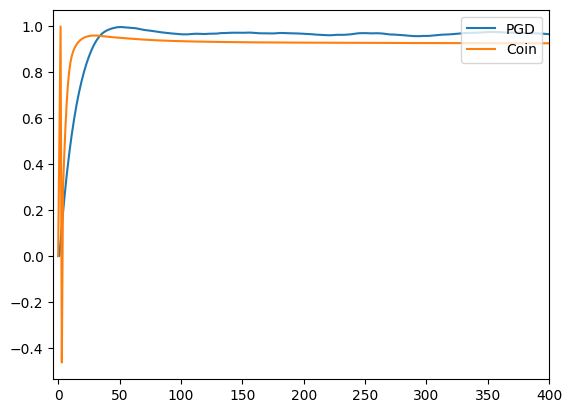

In [287]:
plt.plot(th_pgd.squeeze(), label='PGD')
plt.xlim([-K/100, K])
plt.plot(th_coin.squeeze(), label='Coin')
plt.legend(loc='upper right')

The estimates produced by all five algorithms converge to the same limit after similar transients. To observe more significant differences between the algorithms' outputs, we examine the posterior approximations they return...

# Explicit version

In [290]:
from coinem.model import AbstractModel
from jaxtyping import Array, Float
from dataclasses import dataclass
import jax.numpy as jnp

from jax import grad, vmap

@dataclass
class LogisticRegression(AbstractModel):
    """Base class for p(θ, x)."""
    X: Array # Inputs
    y: Array # Outputs
    
    def log_prob(self, latent: Float[Array, "D"], theta: Float[Array, "Q"]) -> Float[Array, "N"]:

        # Compute linear predictor.
        z = jnp.matmul(self.X, latent[:, None])

        # Compute log-probability.
        return jnp.sum(self.y * z - jnp.log(1.0 + jnp.exp(z))) - jnp.sum((latent[:, None]-theta)**2)/5
    
    def score_latent_particles(self, latent_particles: Float[Array, "N D"], theta: Float[Array, "Q"]) -> Float[Array, "N"]:
        """Returns x-gradient of log density vectorized over particles."""
        s = 1/(1+jnp.exp(- jnp.matmul(self.X, latent_particles.T)))
        return (jnp.matmul((self.y-s).transpose(), self.X).transpose() - (latent_particles.T-theta)/5).T
    
    def average_score_theta(self, latent_particles: Float[Array, "N D"], theta: Float[Array, "Q"]) -> Float[Array, "Q"]:
        """Returns theta-gradient of log density averaged over particle cloud."""

        return jnp.array([[2 * (latent_particles.T-theta).sum(0).mean()/5]])
    
    
    def theta_opt(self, latent_particles: Float[Array, "N D"]) -> Float[Array, "Q"]:
        return latent_particles.mean()  # Return optimal parameter for particle cloud X.
    
    def average_hessian_theta(self, latent_particles: Float[Array, "N D"], theta: Float[Array, "Q"]):
        """Returns negative-theta-Hessian of log density averaged over particles."""
        return jnp.array([[latent_particles.shape[-1]/5]])

In [291]:
from coinem.zoo import coinEM, pgd

# Split data into 80/20 training and testing sets:
from sklearn.model_selection import train_test_split
ftrain, ftest, ltrain, ltest = train_test_split(features, labels, test_size=0.2, 
                                                random_state=0)

likelihood = LogisticRegression(X=ftrain, y=ltrain)

# Set approximation parameters:
h = 1e-2 # Step-size. 
K = 400  # Number of steps.
N = 100  # Number of particles.
D = features[0, :].size  # Dimension of latent space.

# Initialize parameter estimates and particle cloud, all at zero:


import jax.random as jr
th0 = jnp.array([[0.0]])  # Parameter estimate.
key = jr.PRNGKey(42)
X0 = jr.normal(key, (N, D))  # Particle cloud.

# Run algorithms:
# th_vi, X_vi, m_vi, s_vi = vi(ltrain, ftrain, h, K, N, th0, X0)
# th_pgd, X_pgd = pgd(ltrain, ftrain, h, K, N, th0, X0)
# th_pqn, X_pqn = pqn(ltrain, ftrain, h, K, N, th0, X0)
# th_pmgd, X_pmgd = pmgd(ltrain, ftrain, h, K, N, th0, X0)
# th_soul, X_soul = soul(ltrain, ftrain, h, K, N, th0, X0)
X_coin, th_coin = coinEM(likelihood, X0, th0, K)
X_pgd, th_pgd = pgd(likelihood, X0, th0, K, step_size=h)

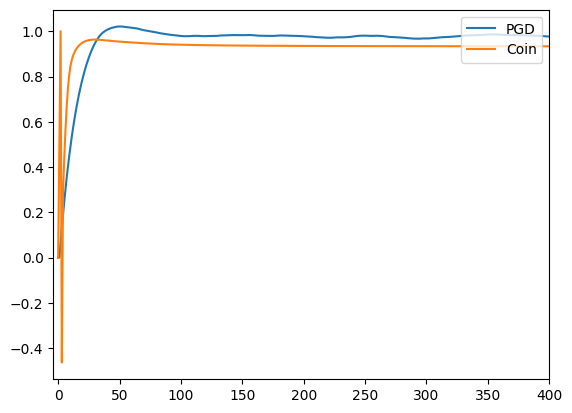

In [292]:
plt.plot(th_pgd.squeeze(), label='PGD')
plt.xlim([-K/100, K])
plt.plot(th_coin.squeeze(), label='Coin')
plt.legend(loc='upper right')